# Programming Exercise 4: Neural Networks Learning

> In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

## 1. Neural Networks

### 1.1 Visualizing the data

> There are 5000 training examples in ex4data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location.

Loading the dataset:

In [9]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mat = scipy.io.loadmat('data/ex4data1.mat')

Visualizing the data:

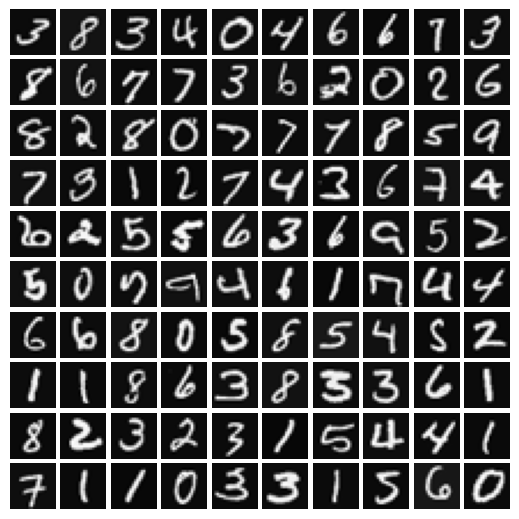

In [10]:
rows = 10  # Number of rows in the grid
cols = 10  # Number of columns in the grid
fig = plt.figure(figsize=(5,5))  # Create a figure object with specified size
indexes = np.random.choice(5000, rows*cols)  # Randomly select indexes from the dataset
count = 0  # Initialize a counter for the index of the current image

# Loop through each row
for i in range(0, rows):
    # Loop through each column
    for j in range(0, cols):
        ax1 = fig.add_subplot(rows, cols, count+1)  # Add a subplot to the figure grid
        # Display the image corresponding to the randomly selected index
        # Reshape the image to a 20x20 matrix, using Fortran-like indexing order
        ax1.imshow(mat['X'][indexes[count]].reshape((20,20), order='F'), cmap='gray')
        ax1.set_axis_off()  # Hide the axes
        count += 1  # Increment the counter

# Adjust the spacing between subplots and margins of the figure
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)
plt.show()  # Display the figure with all subplots


### 1.2 Model representation

<img src="neural_network.png">

* $a_i^{(j)}$ = activation of unit $i$ in layer $j$

* $\Theta^{(j)}$ = matrix of weights controlling function mapping from layer $j$ to layer $j+1$. It's dimension is $s_{j+1}\times(s_j+1)$ where $s_j$ is the number of units in layer $j$ and $s_{j+1}$ is the number of units in layer $j+1$.

* $z^{(j+1)} = \Theta^{(j)}a^{(j)}$

* $h_\Theta(x) = a^{(j+1)} = g(z^{(j+1)}) $



Our neural network has:
* $3$ layers: an input layer, a hidden layer and an output layer
* $400$ input layer units (because the images are of size $20 \times 20$
* $25$ units in the second layer
* $10$ output units (corresponding to the 10 digit classes)
* $\Theta^{(1)}$ and $\Theta^{(2)}$ are provided
    * $\Theta^{(1)}$ has dimension $25 \times 401$
    * $\Theta^{(2)}$ has dimension $10 \times 26$


In [11]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [12]:
mat_weights = scipy.io.loadmat('data/ex4weights.mat')
mat_weights['Theta1'].shape, mat_weights['Theta2'].shape

((25, 401), (10, 26))

Unroll parameters:

In [13]:
nn_params = np.hstack((mat_weights['Theta1'].ravel(order='F'), 
                       mat_weights['Theta2'].ravel(order='F')))

nn_params

array([-0.02256239, -0.09838113,  0.11615605, ..., -2.11014003,
       -2.1319153 , -1.32752042])

### 1.3 Feedforward and cost function

Cost function without regularization

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K [-y_k^{(i)} log((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)})log(1-(h_\theta(x^{(i)}))_k)]$$

In [14]:
import numpy as np
def sigmoid(z):
    z = np.array(z)
    return 1 / (1+np.exp(-z))

In [15]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y):
    # Unroll neural network parameters into theta1 and theta2 matrices
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size+1)], newshape=(hidden_layer_size, input_layer_size+1), order='F')
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size+1):], newshape=(num_labels, hidden_layer_size+1), order='F')
    
    m = X.shape[0]  # Get the number of training examples
    J = 0  # Initialize the cost
    
    K = num_labels  # Number of output classes
    X = np.hstack((np.ones((m,1)), X))  # Add bias unit to the input layer
    
    # Loop through each training example
    for i in range(m):
        a1 = X[i]  # Get the input features for the current example
        
        z2 = a1.dot(theta1.T)  # Compute the input to the hidden layer
        a2 = sigmoid(z2)  # Compute the activation of the hidden layer
        a2 = np.hstack([1, a2])  # Add bias unit to the hidden layer
        
        z3 = a2.dot(theta2.T)  # Compute the input to the output layer
        a3 = sigmoid(z3)  # Compute the activation of the output layer
        
        h = a3  # Predicted output
        
        yk = np.zeros((K,1))  # Initialize yk as a K-dimensional vector
        yk[y[i,0]-1, 0] = 1  # Convert the target label to a binary vector
        
        # Compute the cost for the current example and add it to the total cost
        j = (-yk.T.dot(np.log(h).T) - (1-yk).T.dot(np.log(1-h).T))
        J = J + (j/m)
    return J  # Return the cost


In [16]:
J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, mat['X'], mat['y'])
print('Cost at parameters (loaded from ex4weights): {0} \n(this value should be about 0.287629)'.format(J))

Cost at parameters (loaded from ex4weights): [0.28762917] 
(this value should be about 0.287629)


### 1.4 Regularized cost function

Cost function with regularization for neural network of the example:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K [-y_k^{(i)} log((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)})log(1-(h_\theta(x^{(i)}))_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2] $$

In [17]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r):
    # Unroll neural network parameters into theta1 and theta2 matrices
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size+1)], newshape=(hidden_layer_size, input_layer_size+1), order='F')
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size+1):], newshape=(num_labels, hidden_layer_size+1), order='F')
    
    m = X.shape[0]  # Get the number of training examples
    J = 0  # Initialize the cost
    
    K = num_labels  # Number of output classes
    X = np.hstack((np.ones((m,1)), X))  # Add bias unit to the input layer
    
    # Loop through each training example
    for i in range(m):
        a1 = X[i]  # Get the input features for the current example
        
        z2 = a1.dot(theta1.T)  # Compute the input to the hidden layer
        a2 = sigmoid(z2)  # Compute the activation of the hidden layer
        a2 = np.hstack([1, a2])  # Add bias unit to the hidden layer
        
        z3 = a2.dot(theta2.T)  # Compute the input to the output layer
        a3 = sigmoid(z3)  # Compute the activation of the output layer
        
        h = a3  # Predicted output
        
        yk = np.zeros((K,1))  # Init


In [18]:
lambda_r = 1  # Regularization parameter

# Compute the cost using the provided neural network parameters and regularization parameter
J = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, mat['X'], mat['y'], lambda_r)

# Print the computed cost
print('Cost at parameters (loaded from ex4weights): {0} \n(this value should be about 0.383770)'.format(J))


Cost at parameters (loaded from ex4weights): None 
(this value should be about 0.383770)


## 2. Backpropagation

> In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function.

### 2.1 Sigmoid gradient

$$g'(z) = \frac{d}{dz}g(z) = g(z)(1-g(z))$$ 

where $g(z) = sigmoid(z) = \frac{1}{1+e^{-z}}$ 

In [19]:
def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))

### 2.2 Random initialization
> When training neural networks, it is important to randomly initialize the pa- rameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[−\epsilon_{init}, \epsilon_{init}]$. You should use $\epsilon_{init} = 0.12$.

In [20]:
epsilon_init = 0.12  # Range for random initialization
# Initialize theta1 with random values within the range [-epsilon_init, epsilon_init]
initial_theta1 = np.random.uniform(low=-epsilon_init, high=epsilon_init, size=(hidden_layer_size, input_layer_size+1))
# Initialize theta2 with random values within the range [-epsilon_init, epsilon_init]
initial_theta2 = np.random.uniform(low=-epsilon_init, high=epsilon_init, size=(num_labels, hidden_layer_size+1))


### 2.3 Backpropagation

> Given a training example $(x^{(t)},y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_\Theta(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.

<img src="backpropagation.png">

Algorithm:

1) Set the input layer's values $(a^{(1)})$ to the t-th training example $x^{(t)}$.
Perform a feedforward pass, computing the activations ($z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)}$) for layers 2 and 3.

2) For each output unit $k$ in layer $3$ (the output layer), set 

$$ \delta_k^{(3)} = (a_k^{(3)} - y_k)$$

3) For the hidden layer $l = 2$, set

$$ \delta_k^{(2)} = (\Theta^{(2)})^T \delta^{(3)} .* g'(z^{(2)})$$ 

4) Accumulate the gradient from this example using the following formula. Note that you should skip or remove $\delta_0^{(2)}$

$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T$$

5) Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:

$$ D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}$$

In [21]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r):
    # Unroll neural network parameters into theta1 and theta2 matrices
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size+1)], newshape=(hidden_layer_size, input_layer_size+1), order='F')
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size+1):], newshape=(num_labels, hidden_layer_size+1), order='F')
    
    m = X.shape[0]  # Get the number of training examples
    J = 0  # Initialize the cost
    
    K = num_labels  # Number of output classes
    X = np.hstack((np.ones((m,1)),X))  # Add bias unit to the input layer

    capital_delta1 = np.zeros(theta1.shape)  # Initialize accumulator for gradient of theta1
    capital_delta2 = np.zeros(theta2.shape)  # Initialize accumulator for gradient of theta2
    
    # Loop through each training example
    for i in range(m):
        a1 = X[i]  # Get the input features for the current example
        
        z2 = a1.dot(theta1.T)  # Compute the input to the hidden layer
        a2 = sigmoid(z2)  # Compute the activation of the hidden layer
        a2 = np.hstack([1, a2])  # Add bias unit to the hidden layer
        
        z3 = a2.dot(theta2.T)  # Compute the input to the output layer
        a3 = sigmoid(z3)  # Compute the activation of the output layer
        
        h = a3  # Predicted output
        
        yk = np.zeros((K,1))  # Initialize yk as a K-dimensional vector
        yk[y[i,0]-1, 0] = 1  # Convert the target label to a binary vector
        
        # Compute the cost for the current example and add it to the total cost
        j = (-yk.T.dot(np.log(h).T) - (1-yk).T.dot(np.log(1-h).T)) ##sum of K
        J = J + (j/m) #sum of i
        
        # Compute the error in the output layer
        delta3 = a3 - yk.T
        
        # Compute the error in the hidden layer
        z2 = np.hstack([1, z2])  # Add bias unit to the input to the hidden layer
        delta2 = theta2.T.dot(delta3.T) * (sigmoid_gradient(z2).reshape(-1,1))
        
        # Accumulate the gradients
        capital_delta1 = capital_delta1 + (delta2[1:,:].dot(a1.reshape(1,-1)))
        capital_delta2 = capital_delta2 + (delta3.T.dot(a2.reshape(1,-1)))
        
    # Compute regularization term
    sum1 = np.sum(np.sum(theta1[:, 1:] ** 2))
    sum2 = np.sum(np.sum(theta2[:, 1:] ** 2))
    J = J + (lambda_r / (2*m)) * (sum1 + sum2)
    
    # Compute gradients with regularization
    theta1_grad = (1/m) * (capital_delta1 + lambda_r * theta1)
    theta1_grad[:,0] = ((1/m) * capital_delta1)[:,0]
    
    theta2_grad = (1/m) * (capital_delta2 + lambda_r * theta2)
    theta2_grad[:,0] = ((1/m) * capital_delta2)[:,0]
    
    # Unroll gradients into a single vector
    grad = np.hstack((theta1_grad.ravel(order='F'), theta2_grad.ravel(order='F')))
    
    return J, grad  # Return the cost and gradient


### 2.4 Gradient Checking

> In your neural network, you are minimizing the cost function $J(\Theta)$. To perform gradient checking on your parameters, you can imagine “unrolling” the parameters $\Theta^{(1)}, \Theta^{(2)}$ into a long vector $\theta$. By doing so, you can think of the cost function being $J(\theta)$ instead and use the following gradient checking procedure. Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values. If $\theta^{(i+)}$ is the same $\theta$, except its i-th element has been incremented by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that: $f_i(\theta) 	\approx \frac{J(\theta^{(i+)} - J(\theta^{(i-)}}{2\epsilon}$. The degree to which these two values should approximate each other will depend on the details of $J$. But assuming $\epsilon = 10^{−4}$, you’ll usually find that the left- and right-hand sides of the above will agree to at least 4 significant digits (and often many more).

In [22]:
def compute_numerical_gradient(theta, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r):
    e = 0.0001  # Small value for perturbation
    num_grad = np.zeros(theta.shape)  # Initialize numerical gradient
    perturb = np.zeros(theta.shape)  # Initialize perturbation vector
    
    # Loop through each parameter in theta
    for p in range(len(theta)):
        perturb[p] = e  # Set perturbation for the current parameter
        # Compute the cost for theta-perturb
        loss1, _ = nn_cost_function(theta - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r)
        # Compute the cost for theta+perturb
        loss2, _ = nn_cost_function(theta + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r)
        # Compute the numerical gradient for the current parameter
        num_grad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0  # Reset perturbation for the current parameter
        
    return num_grad  # Return the numerical gradient


In [23]:
def debug_initialize_weights(fan_out, fan_in):
    # Initialize weight matrix with zeros
    W = np.zeros((fan_out, 1+fan_in))
    # Reshape the weight matrix into a 1-dimensional array and initialize values from 0 to len(W) - 1 divided by 10
    W = np.reshape(range(len(W.ravel(order='F'))), W.shape) / 10
    return W  # Return the initialized weight matrix


In [24]:
def check_nn_gradients(lambda_r=0):
    # Define the sizes of layers and number of examples
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # Initialize random theta values and input data
    theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    theta2 = debug_initialize_weights(num_labels, hidden_layer_size)
    
    X = debug_initialize_weights(m, input_layer_size-1)
    y = 1 + np.mod(range(m), num_labels).reshape(-1, 1)
    
    # Concatenate the theta parameters into a single vector
    nn_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F')))
    
    # Compute cost and gradients using backpropagation
    cost, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r)
    # Compute numerical gradients for comparison
    num_grad = compute_numerical_gradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_r)
    
    # Print comparison of numerical gradients and gradients computed by backpropagation
    print('The columns should be very similar...')
    for i, j in zip(num_grad, grad):
        print(i, j)
        
    # Compute relative difference between numerical and backpropagated gradients
    diff = np.linalg.norm(num_grad-grad) / np.linalg.norm(num_grad+grad)
    
    # Check if the difference is within tolerance
    if diff < 0.000000010:
        print('\nBackpropagation is correct')
    else:
        print('\nBackpropagation is incorrect')


In [25]:
check_nn_gradients()

The columns should be very similar...
0.3508102791105472 0.3508102782483561
0.2353522188158763 0.23535221882914456
0.1452979107607888 0.14529791114175525
0.09315199914539107 0.09315199923194291
0.06032069570061083 0.06032069599693199
0.1937398015439129 0.19373980185067552
0.08735383096869498 0.0873538307836033
0.029773973508895324 0.029773974437035562
0.010590364460938417 0.010590364574492521
0.004047666530837546 0.00404766588020231
0.2288208313494522 0.22882082967551112
0.11088905266909421 0.11088905266651777
0.04430376599806607 0.04430376555121108
0.019905564396793807 0.01990556449768681
0.010079735703882875 0.010079735479895512
0.26390185717595216 0.2639018575003467
0.1344242739431678 0.1344242745494322
0.058833556648707486 0.0588335566653866
0.029220764217186 0.029220764420881108
0.01611180537430812 0.01611180507958871
0.39622224609736634 0.3962222462654107
0.5887339968513317 0.588733996850061
0.7994663673738245 0.7994663670394307
0.24984228291557997 0.2498422829571028
0.3490656134

In [26]:
lambda_r = 3  # Regularization parameter

# Perform gradient checking
check_nn_gradients(lambda_r)

# Compute cost and gradients using the provided neural network parameters and regularization parameter
J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, mat['X'], mat['y'], lambda_r)

# Print the computed cost
print('Cost at parameters (loaded from ex4weights): {0} \n(this value should be about 0.576051)'.format(J))


The columns should be very similar...
0.35081027911942897 0.3508102782483561
0.2353522188158763 0.23535221882914456
0.145297910751907 0.14529791114175525
0.09315199914539107 0.09315199923194291
0.06032069569172904 0.06032069599693199
0.2537398015434178 0.2537398018506755
0.38735383096621945 0.3873538307836033
0.5697739734955576 0.5697739744370356
0.7905903644456203 0.7905903645744927
1.0240476665224207 1.0240476658802022
0.348820831348462 0.34882082967551115
0.47088905267500536 0.47088905266651776
0.6443037660019968 0.6443037655512112
0.8599055643898623 0.8599055644976867
1.0900797357216163 1.0900797354798957
0.44390185717446684 0.4439018575003467
0.5544242739397021 0.5544242745494321
0.7188335566432613 0.7188335566653867
0.9292207642097594 0.9292207644208812
1.1561118053826647 1.1561118050795887
0.39622224608848455 0.3962222462654107
0.5887339968602134 0.588733996850061
0.7994663673827063 0.7994663670394307
0.30984228292396665 0.3098422829571028
0.7690656134862195 0.769065613486773
1.

### 2.5 Learning Parameters - Training the Neural Network

In [27]:
import scipy.optimize as opt

lambda_r = 1  # Regularization parameter

# Use scipy's optimization function to minimize the neural network cost function
opt_results = opt.minimize(nn_cost_function,  # Function to minimize
                           nn_params,  # Initial guess for neural network parameters
                           args=(input_layer_size, hidden_layer_size, num_labels, mat['X'], mat['y'], lambda_r),  # Additional arguments for nn_cost_function
                           method='L-BFGS-B',  # Optimization method: L-BFGS-B
                           jac=True,  # Indicates that the cost function returns both the cost and gradients
                           options={'maxiter': 50})  # Maximum number of iterations

# The optimized neural network parameters can be accessed via opt_results['x']


In [28]:
opt_results

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 0.3172211645306451
        x: [-6.389e-02 -1.301e-01 ... -2.874e+00 -1.749e+00]
      nit: 50
      jac: [ 2.311e-04 -9.153e-05 ... -2.895e-05  2.217e-05]
     nfev: 55
     njev: 55
 hess_inv: <10285x10285 LbfgsInvHessProduct with dtype=float64>

In [29]:
# Reshape the optimized parameters into the shape of theta1 matrix
theta1 = np.reshape(opt_results['x'][:hidden_layer_size * (input_layer_size+1)],
                    newshape=(hidden_layer_size, input_layer_size+1),
                    order='F')

# Reshape the optimized parameters into the shape of theta2 matrix
theta2 = np.reshape(opt_results['x'][hidden_layer_size * (input_layer_size+1):],
                    newshape=(num_labels, hidden_layer_size+1),
                    order='F')


In [30]:
def predict_nn(theta1, theta2, X):
    m, n = X.shape  # Get the number of examples (m) and features (n)
    
    # Add bias unit to the input layer (a1)
    a1 = np.hstack((np.ones((m,1)), X))
    
    # Compute the input to the hidden layer (z2) and the activation of the hidden layer (a2)
    z2 = a1.dot(theta1.T)
    a2 = sigmoid(z2)
    
    # Add bias unit to the hidden layer (a2)
    a2 = np.hstack((np.ones((m,1)), a2))
    
    # Compute the input to the output layer (z3) and the activation of the output layer (a3)
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3)
    
    # Predict the labels by selecting the index of the maximum value in each row of a3 (plus one to match the label convention)
    h = np.argmax(a3, axis=1) + 1
    
    return h


In [31]:
# Predict labels for the input data using the trained parameters theta1 and theta2
y_pred = predict_nn(theta1, theta2, mat['X'])

# Compute the accuracy by comparing predicted labels (y_pred) with actual labels (mat['y'])
accuracy = np.mean(y_pred == mat['y'].T)

# Format and print the training accuracy
f'Train accuracy: {accuracy * 100}'


'Train accuracy: 99.24'

#### 2.5.1 Similar Code using Scikit-Learn:

In [32]:
from sklearn.neural_network import MLPClassifier

# Create an MLPClassifier object with specified parameters
# hidden_layer_sizes: Tuple specifying the number of neurons in the hidden layer(s)
# activation: Activation function for the hidden layer ('logistic' for sigmoid)
# solver: Optimization algorithm ('lbfgs' is used here, which is a quasi-Newton method)
# alpha: Regularization parameter (L2 penalty term)
# max_iter: Maximum number of iterations for optimization
nn = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,),  # Specify hidden layer size
                   activation='logistic',  # Use logistic sigmoid activation function
                   solver='lbfgs',  # Use L-BFGS optimization algorithm
                   alpha=1,  # Regularization parameter
                   max_iter=50)  # Maximum number of iterations

# Train the neural network model using the provided data mat['X'] and labels mat['y'].T[0]
nn.fit(mat['X'], mat['y'].T[0])


/home/muhammad/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='logistic', alpha=1, hidden_layer_sizes=(25,),
              max_iter=50, solver='lbfgs')

In [33]:
nn.score(mat['X'], mat['y'].T[0])

0.9816

## 3. Visualizing the hidden layer

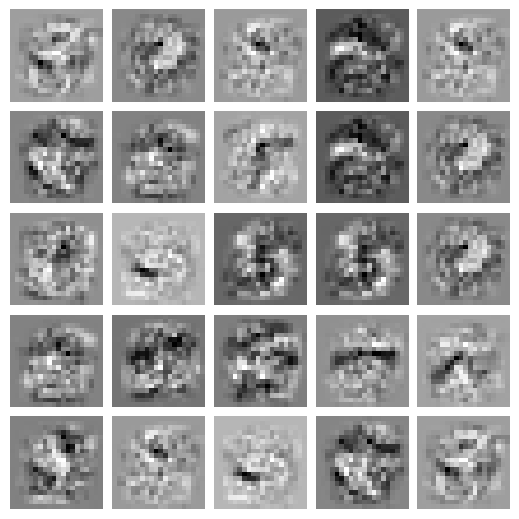

In [34]:
rows = 5  # Number of rows in the subplot grid
cols = 5  # Number of columns in the subplot grid

# Create a new figure
fig = plt.figure(figsize=(5,5))

# Select a random subset of indexes for the learned features
indexes = np.random.choice(25, rows*cols)

count = 0  # Initialize a counter

# Loop through each subplot position
for i in range(0, rows):
    for j in range(0, cols):
        # Add a subplot to the figure
        ax1 = fig.add_subplot(rows, cols, count+1)
        
        # Display the learned feature corresponding to the selected index
        ax1.imshow(theta1[:,1:][indexes[count]].reshape((20,20), order='F'), cmap='gray')
        
        # Turn off axis
        ax1.set_axis_off()
        
        count += 1  # Increment the counter

# Adjust spacing between subplots
plt.subplots_adjust(wspace=.1, hspace=.1, left=0, right=1, bottom=0, top=1)

# Show the plot
plt.show()


### 3.1 Trying Different Learning Settings

> Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to “overfit” a training set so that it obtains close to 100% accuracy on the training set but does not as well on new examples that it has not seen before.

In [35]:
%%time

lambda_r = 0.1  # Regularization parameter

# Optimize the neural network parameters using TNC optimization algorithm
opt_results = opt.minimize(nn_cost_function,  # Function to minimize
                            nn_params,  # Initial guess for neural network parameters
                            args=(input_layer_size, hidden_layer_size, num_labels, mat['X'], mat['y'], lambda_r),  # Additional arguments for nn_cost_function
                            method='TNC',  # Optimization method: TNC
                            jac=True,  # Indicates that the cost function returns both the cost and gradients
                            options={'maxiter': 100})  # Maximum number of iterations

# Reshape the optimized parameters into theta1 and theta2 matrices
theta1 = np.reshape(opt_results['x'][:hidden_layer_size * (input_layer_size+1)],
                    newshape=(hidden_layer_size, input_layer_size+1),
                    order='F')
theta2 = np.reshape(opt_results['x'][hidden_layer_size * (input_layer_size+1):],
                    newshape=(num_labels, hidden_layer_size+1),
                    order='F')

# Predict labels for the input data using the optimized parameters
y_pred = predict_nn(theta1, theta2, mat['X'])

# Compute the accuracy by comparing predicted labels with actual labels
accuracy = np.mean(y_pred == mat['y'].T)


<timed exec>:4: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.


CPU times: user 5min 20s, sys: 3min 41s, total: 9min 2s
Wall time: 2min 22s


In [36]:
f'Train accuracy with lambda={lambda_r} and maxiter=50: {accuracy * 100}'

'Train accuracy with lambda=0.1 and maxiter=50: 99.98'

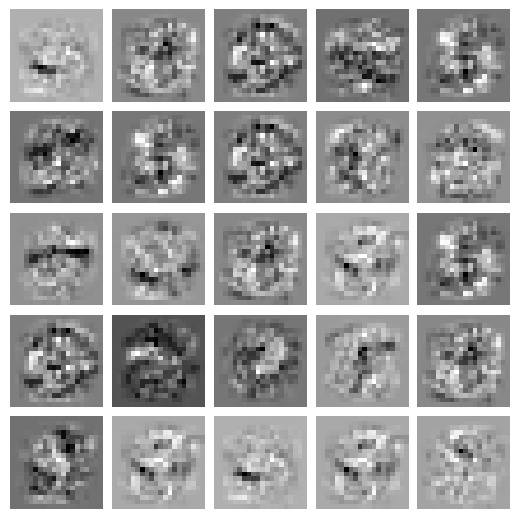

In [37]:
rows = 5  # Number of rows in the subplot grid
cols = 5  # Number of columns in the subplot grid

# Create a new figure with specified size
fig = plt.figure(figsize=(5, 5))

# Select a random subset of indexes for the learned features
indexes = np.random.choice(25, rows * cols)

count = 0  # Initialize a counter

# Loop through each subplot position
for i in range(rows):
    for j in range(cols):
        # Add a subplot to the figure
        ax1 = fig.add_subplot(rows, cols, count+1)
        
        # Display the learned feature corresponding to the selected index
        ax1.imshow(theta1[:, 1:][indexes[count]].reshape((20, 20), order='F'), cmap='gray')
        
        # Turn off axis
        ax1.set_axis_off()
        
        count += 1  # Increment the counter

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0, right=1, bottom=0, top=1)

# Show the plot
plt.show()
